# 1 Setup

In this module, we will use a CNN to identify and classify distracted driving practices into 1 of 10 categories.

In [1]:
# fastai library imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import *

In [2]:
# env config
PATH = "./data/"
sz = 256
arch = resnet34
batch_size = 30

In [3]:
# set up k-folds cross validation
label_csv = f'{PATH}driver_imgs_list.csv'
n = len(list(open(label_csv))) - 1
val = get_cv_idxs(n)

# 2 Initial Exploration

In this section, we explore the data to understand what we're working with.

In [4]:
# path exploration
!ls {PATH}

directory_organization.ipynb  models			 tmp
driver_imgs_list.csv	      sample_submission.csv	 train
driver_imgs_list.csv.zip      sample_submission.csv.zip  valid
imgs.zip		      test


In [5]:
# create a pandas dataframe to explore labels
label_df = pd.read_csv(label_csv)
label_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


Now, let's see how many of each class exists

In [6]:
label_df.pivot_table(index='classname', aggfunc=len).sort_values('img', ascending=False)

,img,subject
classname,,
c0,2489,2489
c3,2346,2346
c4,2326,2326
c6,2325,2325
c2,2317,2317
c5,2312,2312
c1,2267,2267
c9,2129,2129
c7,2002,2002


# 3 Initial Model

## 3.1 Precompute

In this section, we will retain all the precomputed activations of the resnext101_64 architecture to obtain a base model.

In [7]:
# transform/augment data and read it
def get_data(sz, batch_size):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name="test")
    return data

In [8]:
# get data in desired format
data = get_data(sz, batch_size)

Let's view some images in the training set at random

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'./data/train/c0/img_66661.jpg'

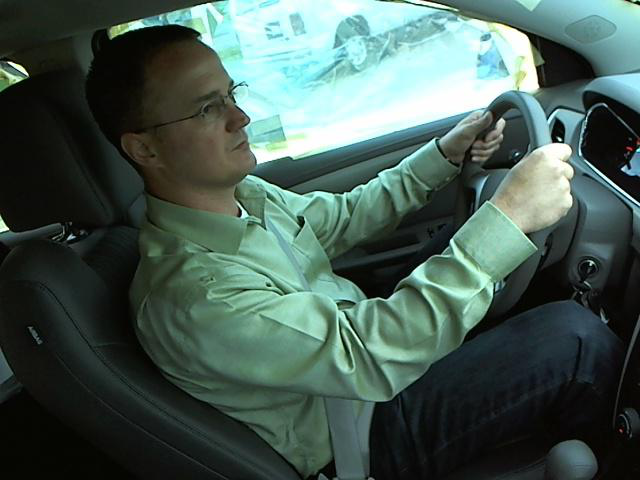

In [10]:
img = PIL.Image.open(fn); img

In [11]:
img.size

(640, 480)

In [12]:
fn2 = PATH+data.trn_ds.fnames[20]; fn2

'./data/train/c0/img_64622.jpg'

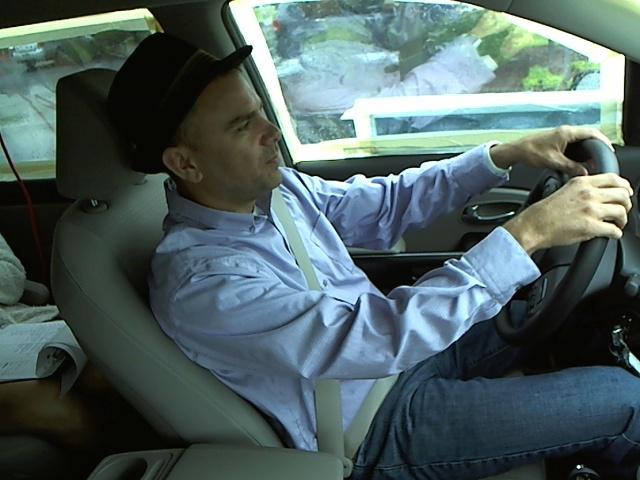

In [13]:
img2 = PIL.Image.open(fn2); img2

At this point, we notice that the images are normal (no anomalies) and that the driver takes up the majority of the frame

In [14]:
# run precomputed resnet34 model on our current dataset
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [15]:
# use cyclic learning rate finder to generate lr plot# use cy 
lrf = learn.lr_find();

 82%|████████▏ | 238/289 [00:04<00:01, 50.73it/s, loss=5.5] 


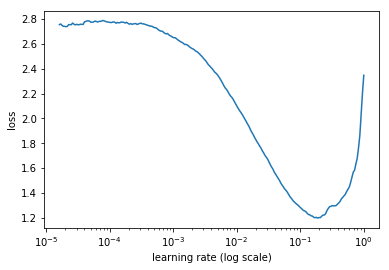

In [16]:
# plot the lr discovered to visualize and find optimal lr# plot t 
learn.sched.plot()

In [17]:
learn.fit(0.05, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.300966   1.355005   0.599188  
    1      0.21789    1.263513   0.631152                    
    2      0.147515   1.224281   0.630644                    
    3      0.17889    1.351782   0.627093                    
    4      0.117639   1.246472   0.634703                    
    5      0.100857   1.234424   0.631405                     
    6      0.101317   1.232193   0.626585                     



[array([1.23219]), 0.6265854896143086]

## 3.2 Disable Precompute

We can now disable precompute to allow the last two layers' weights to be adjusted for the current dataset

In [18]:
learn.precompute = False

In [19]:
learn.fit(0.05, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.482347   1.018549   0.66413   
    1      0.408451   0.986831   0.674277                    
    2      0.348188   1.012382   0.667174                    



[array([1.01238]), 0.6671740232930456]

In [20]:
learn.save('256_pre')
learn.load('256_pre')

## 3.3 Increasing Size 

We will now increase the size of the images to 299x299 which will help avoid overfitting and generalize over the dataset

In [ ]:
learn.set_data(get_data(512, batch_size))
learn.freeze() # freeze again just to be sure

In [ ]:
# refit on new image sizes
learn.fit(0.05, 3, cycle_len=1)

## 3.4 Differential Learning Rate Annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers.

In [19]:
# unfreeze all layers
learn.unfreeze()

We will apply differential rate annealing to train the earlier layers with lower learning rates. We do this because earlier layers have more general purpose functions that are not as specific to the current dataset and hence, require lesser fine tuning.

In [22]:
lr=np.array([1e-2/4,1e-2/2,1e-2])

## 3.5 Modifying Epochs

In this section, we will play around with the epochs to try and maximize the effects of the stochastic gradient descent with random restarts. To do so, we will set cycle_mult=2 so that the number of epochs is doubled in each cycle. Doing this also helps avoid underfitting by allowing more time to find global minima.

In [23]:
# refit with cycle_mult=2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.090271   0.394354   0.86758   
    1      0.04528    0.45504    0.853628                     
    2      0.024897   0.39123    0.864789                     
    3      0.029158   0.441847   0.862253                     
    4      0.013507   0.411543   0.872907                     
    5      0.010808   0.423047   0.863267                      
    6      0.006628   0.430181   0.863267                      



[array([0.43018]), 0.8632673768904051]

In [27]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), probs.shape

(0.8800101471334348, (3942, 10))

## 3.6 Predicting on Test Data

We will now use this model that has achieved ~86% accuracy on the training set to make predictions on the test set.

In [24]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

(0.09614178561573389, (79726, 10))

## 3.7 A Look at the Architecture 

In this section, we will take a deeper look at the resnet34 architecture used to complete this challenge.

In [21]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 64

**We can see that the architecture is a pretty typical CNN architecture. There are several convolutional layers each containing a convolutional kernel intended to help the neural net learn a particular feature/characteristic about the images under consideration. Furthermore, there also exist nonlinearities (in the form of ReLU's) that allow the layers to be stacked to form a more effective deep learning model. We also note the existence of the max pooling layers, which "pool" or aggregate the features learned from the preceeding convolutional layers more succinctly by performing a dimensionality reduction on the vector of learned features. The final layer applies a log softmax function to produce probabilities that are in the range `[0, 1)`. Since this is a single label classification problem, a log softmax activation function works very well for the output layer. Hence, we use a pretty typical CNN architecture derived from the widely used resnet34 model, with modifications to suit our dataset.**

# 4 Creating a Kaggle Submission


In [72]:
ds = pd.DataFrame(probs)
ds.columns = data.classes
id_series = pd.Series([o[5:] for o in data.test_ds.fnames])
ds.insert(0, 'img', id_series)
ds.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_37990.jpg,0.164161,0.000861,0.000480,0.012853,0.182442,0.029252,0.014004,0.002332,0.465342,0.128274
1,img_79092.jpg,0.798081,0.191597,0.000069,0.000075,0.000188,0.003131,0.000073,0.000051,0.002907,0.003827
2,img_55859.jpg,0.611356,0.011177,0.001075,0.000724,0.104717,0.088904,0.001509,0.000151,0.117562,0.062825
3,img_92870.jpg,0.968950,0.000024,0.000002,0.000016,0.000212,0.004745,0.000009,0.000037,0.000603,0.025401
4,img_20844.jpg,0.003884,0.000737,0.097377,0.000011,0.041802,0.001777,0.041698,0.003865,0.780506,0.028343


In [73]:
!mkdir subm # make directory called 'subm'

In [74]:
ds.to_csv(f'subm/subm.gz', compression='gzip', index=False)